<a href="https://colab.research.google.com/github/rakshith291/ViT/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
import math
import numpy as np 
tf.config.run_functions_eagerly(True)

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'att':self.att,
            'ffn':self.ffn,
            'layernorm1':self.layernorm1,
            'layernorm2':self.layernorm2,
            'dropout1':self.dropout1,
            'dropout2':self.dropout2
        })
        return config

    def call(self, inputs, training):
        attn_output,attn_scores = self.att(inputs, inputs,return_attention_scores = True)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output),attn_scores

In [ ]:
class TokenEmbedding(layers.Layer):
  def __init__(self,num_pathces,proj_dim):
    super(TokenEmbedding,self).__init__()
    self.num_patches = num_patches
    self.dense_projection = layers.Dense(proj_dim)  # linear projection
    self.pos_emb = layers.Embedding(input_dim=num_patches, output_dim=proj_dim)
    
    
  def get_config(self):
    config = super().get_config().copy()
    config.update({
        'num_patches':self.num_patches,
        'dense_projection':self.dense_projection,
        'pos_emb':self.pos_emb
    })
    return config

  def call(self,inputs):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    embeddings = self.dense_projection(inputs)
    positions = self.pos_emb(positions)
    return embeddings + positions


In [ ]:
class Patch_creation(layers.Layer) :
  def __init__(self,num_patches_h,num_patches_w,patch_h,patch_w,embed_dim):
    super(Patch_creation,self).__init__()
    self.num_patches_h = num_patches_h
    self.num_patches_w = num_patches_w
    self.patch_h = patch_h
    self.patch_w = patch_w
    self.num_patches = self.num_patches_h*self.num_patches_w
    self.embed_dim = embed_dim
    self.flatten = layers.Flatten()
    

  def get_config(self):
    config = super().get_config().copy()
    config.update({
        'num_patches_h':self.num_patches_h,
        'num_patches_w':self.num_patches_w,
        'patch_h': self.patch_h,
        'patch_w': self.patch_w,
        'num_patches': self.num_patches_h*self.num_patches_w,
        'flatten': self.flatten,
        'embed_dim':self.embed_dim
    })
    return config 

  @tf.function
  def call(self,imgs):
    self.patches = tf.Variable([[[0]*(self.patch_h*self.patch_w*3) for i in range(self.num_patches)]],shape=[None,self.num_patches,(self.patch_h*self.patch_w*3)],dtype=tf.float32,validate_shape=False,trainable=False)
    if imgs.shape[0] is not None :
      self.patches = tf.Variable(tf.zeros(shape=(imgs.shape[0],self.num_patches,self.patch_h*self.patch_w*3)),shape=tf.TensorShape([imgs.shape[0],self.num_patches,self.patch_h*self.patch_w*3]),dtype='float32',validate_shape=False,trainable=False)
    for n_h in range(self.num_patches_h):
      for n_w in range(self.num_patches_w) :
        patch = imgs[:,n_h*self.patch_h:(n_h+1)*self.patch_h,(n_w)*self.patch_w:(n_w+1)*self.patch_w,:]
        patch = self.flatten(patch)
        patch = tf.cast(patch,tf.float32)
        self.patches[:,n_h*self.num_patches_w+n_w,:].assign(patch)
        
    return tf.convert_to_tensor(self.patches)


In [ ]:
embed_dim = 64
num_patches_h = 8
num_patches_w = 8
patch_h = 8
patch_w = 8
num_patches = 64
num_heads = 12 
ffn_dim = 128
image_size = 64

In [ ]:
data_augumentation = tf.keras.Sequential(
    [
     layers.experimental.preprocessing.Rescaling(scale=1./255),
     layers.experimental.preprocessing.Resizing(image_size, image_size),
     layers.experimental.preprocessing.RandomFlip("horizontal")
    ]
)

In [ ]:
inputs = layers.Input(shape=(32,32,3))
augumented_data = data_augumentation(inputs)
create_patches = Patch_creation(num_patches_h,num_patches_w,patch_h,patch_w,embed_dim)
patches = create_patches(augumented_data)
tokens = TokenEmbedding(num_patches,embed_dim)
embeddings = tokens(patches)

transformer_block = TransformerBlock(embed_dim,num_heads, ffn_dim)
for  i in range(12):
  embeddings ,attn_scores = transformer_block(embeddings)


x = layers.GlobalAveragePooling1D()(embeddings)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)




In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

class myCallBack:
    def custom_callbacks(self):
      my_callbacks = [
                      EarlyStopping(monitor='val_loss',patience=10,min_delta=0.01),
                      ModelCheckpoint('model_1.h5',monitor='val_accuracy',save_best_only=True)
                      
      ]
      return my_callbacks

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
y_train = utils.to_categorical(y_train,10) # CIFAR-10 
y_test = utils.to_categorical(y_test,10)


170500096/170498071 [==============================] - 4s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64, 64, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
patch_creation (Patch_creation) (None, 64, 192)      0           sequential[0][0]                 
__________________________________________________________________________________________________
token_embedding (TokenEmbedding (None, 64, 64)       16448       patch_creation[0][0]             
______________________________________________________________________________________________

In [ ]:
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    0.001, 58800)
optimizer = tf.keras.optimizers.SGD(
    learning_rate= lr_decayed_fn, momentum=0.9, nesterov=False, name="SGD"
)

model.compile(optimizer=optimizer,loss=tf.keras.losses.CategoricalCrossentropy(),metrics=["accuracy"])

callbacks_custom = myCallBack()
callbacks = callbacks_custom.custom_callbacks()

history = model.fit(
    x_train, y_train, batch_size=256, epochs=300, validation_data=(x_test, y_test),callbacks=callbacks
)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/300
196/196 [==============================] - 94s 466ms/step - loss: 2.5517 - accuracy: 0.1270 - val_loss: 2.0584 - val_accuracy: 0.2073
Epoch 2/300
125/196 [==================>...........] - ETA: 30s - loss: 2.0914 - accuracy: 0.2127

In [ ]:
inputs = layers.Input(shape=input_shape)
augumented_data = data_augumentation(input)
patches = path_creation()

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
y_train = utils.to_categorical(y_train,10) # CIFAR-10 
y_test = utils.to_categorical(y_test,10)

In [ ]:
x_train_sample = patch_creation(x_train,16,8,8,y_train)

In [ ]:
import matplotlib.pyplot as plt
for i in range(2):
  
  a = x_train_sample[i]
  b = a[0]
  for x in range(16):
    y = b[x]
    plt.imshow(b[x])
  c = a[1]
  print(len(a),b.shape,c.shape)
  print(c)


2 (16, 8, 8, 3) (10,)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
2 (16, 8, 8, 3) (10,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
img_inputs = x_train[12225:12227]
patches = Patch_creation(2,2,16,16)(img_inputs)

In [ ]:
patches.shape

(2, 4, 768)

In [ ]:
b = np.reshape(patches,(2,4,16,16,3))

In [ ]:
import matplotlib.pyplot as plt

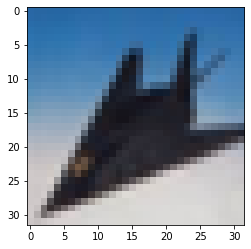

In [ ]:
plt.imshow(x_train[12226])

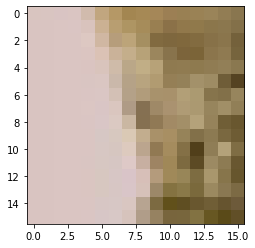

In [ ]:
plt.imshow(b[0,2,:,:,:])

In [ ]:
inputs = layers.Input([shape=(32,32,3),shape=(1)])

SyntaxError: ignored

In [ ]:
l =[1,2,3]
a =tf.convert_to_tensor(l)

In [ ]:
l.append(a)

In [ ]:
a = tf.random.uniform(shape=(4,2,192))

In [ ]:
a[:,0]

<tf.Tensor: shape=(4, 192), dtype=float32, numpy=
array([[2.39748001e-01, 4.34899330e-03, 1.63258195e-01, 1.31509066e-01,
        4.09476876e-01, 5.34734726e-01, 1.62474990e-01, 5.00323772e-01,
        8.62744927e-01, 5.01793981e-01, 3.66892338e-01, 7.88530469e-01,
        1.38440132e-02, 3.21278453e-01, 7.66208291e-01, 7.81457543e-01,
        6.69760108e-01, 6.33648396e-01, 5.47907472e-01, 8.35991383e-01,
        3.47038746e-01, 7.81538248e-01, 3.69508743e-01, 1.30779624e-01,
        2.40335703e-01, 2.03930259e-01, 8.85975599e-01, 2.82857418e-01,
        3.65791321e-01, 1.69463158e-01, 6.10300899e-01, 3.16799760e-01,
        4.60190892e-01, 3.69047523e-01, 3.47949982e-01, 7.10657716e-01,
        4.62491512e-01, 5.20546317e-01, 8.08358788e-01, 7.72191405e-01,
        1.37039185e-01, 5.48231244e-01, 2.44927168e-01, 6.21354938e-01,
        6.59569979e-01, 4.76153851e-01, 7.58349419e-01, 6.96958661e-01,
        3.03269506e-01, 6.56672120e-01, 5.03063202e-04, 8.17839622e-01,
        4.7905